In [1]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from PIL import Image

In [3]:
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
image_path = "./datasets"
walk_through_dir(image_path)

There are 3 directories and 1 images in './datasets'.
There are 0 directories and 500 images in './datasets\test'.
There are 2 directories and 0 images in './datasets\train'.
There are 0 directories and 10000 images in './datasets\train\cat'.
There are 0 directories and 10000 images in './datasets\train\dog'.
There are 2 directories and 0 images in './datasets\val'.
There are 0 directories and 2500 images in './datasets\val\cat'.
There are 0 directories and 2500 images in './datasets\val\dog'.


Random image path: ./datasets\test\233.jpg
Image class: test
Image height: 500
Image width: 296


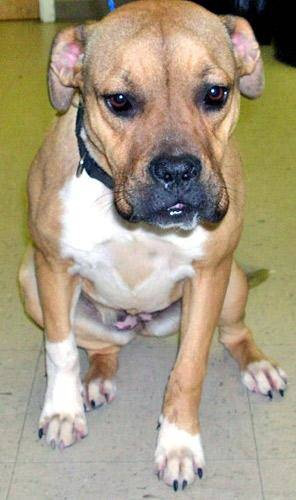

In [4]:
import glob
import random
from pathlib import Path

train_dir = 'datasets/train'
val_dir = 'datasets/val'
test_dir = 'datasets/test'

# train_dir = os.path.join(data, 'train')
# val_dir = os.path.join(data, 'val')
# test_dir = os.path.join(data, 'test')

# Get all image paths
image_path_list = glob.glob(f"{image_path}/*/*.jpg")

# Get random image path
random_image_path = random.choice(image_path_list)

# Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = Path(random_image_path).parent.stem

# Open image
img = Image.open(random_image_path)

# Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

(-0.5, 295.5, 499.5, -0.5)

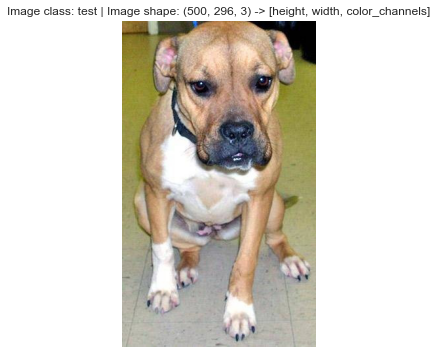

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

In [6]:
# Data augmentation
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

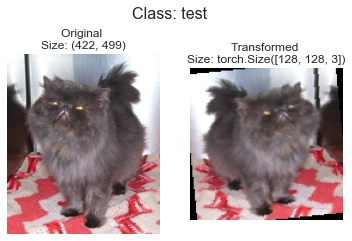

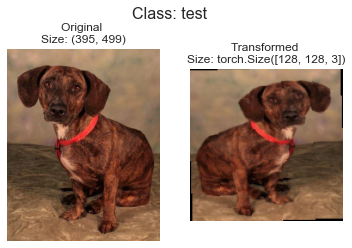

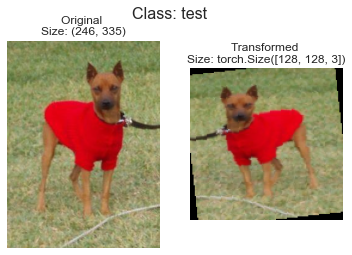

In [7]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"Class: {Path(random_image_path).parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, transform=data_transforms, n=3)

In [8]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transforms,
                                  target_transform=None)
val_data = datasets.ImageFolder(root=val_dir,
                               transform=data_transforms)

In [9]:
num_train_samples = 5000
num_val_samples = 1000

In [10]:
from collections import defaultdict
from torch.utils.data import DataLoader, Subset

np.random.seed(42)  # For reproducibility

# Get class indices for training data
class_indices_train = defaultdict(list)
for idx, (path, label) in enumerate(train_data.samples):
    class_indices_train[label].append(idx)

# Number of classes (should be 2: 'cat' and 'dog')
num_classes = len(train_data.classes)
samples_per_class_train = num_train_samples // num_classes

selected_indices_train = []
for label in class_indices_train:
    indices = class_indices_train[label]
    np.random.shuffle(indices)
    selected_indices_train.extend(indices[:samples_per_class_train])

# Create subset for training data
train_data = Subset(train_data, selected_indices_train)

In [11]:
# Get class indices for validation data
class_indices_val = defaultdict(list)
for idx, (path, label) in enumerate(val_data.samples):
    class_indices_val[label].append(idx)

samples_per_class_val = num_val_samples // num_classes

selected_indices_val = []
for label in class_indices_val:
    indices = class_indices_val[label]
    np.random.shuffle(indices)
    selected_indices_val.extend(indices[:samples_per_class_val])

# Create subset for validation data
val_data = Subset(val_data, selected_indices_val)

In [12]:
from torch.utils.data import DataLoader

batch_size = 32  # Adjust as needed

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)

In [13]:
from torch.utils.data import Dataset
from PIL import Image
import os

class TestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.transform = transform
        self.image_filenames = [fname for fname in os.listdir(test_dir)
                                if fname.endswith('.jpg') or fname.endswith('.png')]
        self.image_filenames.sort()  # Ensure consistent order

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.test_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, img_name  # Return image and its filename (ID)


In [14]:
test_data = TestDataset(test_dir, transform=data_transforms)

test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

In [15]:
from collections import Counter

# For training data
subset_targets_train = [train_data[i][1] for i in range(len(train_data))]
class_counts_train = Counter(subset_targets_train)
print(f'Class distribution in training subset: {class_counts_train}')

Class distribution in training subset: Counter({0: 2500, 1: 2500})


In [16]:
# For validation data
subset_targets_val = [val_data[i][1] for i in range(len(val_data))]
class_counts_val = Counter(subset_targets_val)
print(f'Class distribution in validation subset: {class_counts_val}')

Class distribution in validation subset: Counter({0: 500, 1: 500})


In [17]:
train_loader

In [18]:
class_names = train_data.dataset.classes
print("Class names: ", class_names)

# Can also get class names as a dict
class_dict = train_data.dataset.class_to_idx
print("Class names as a dict: ", class_dict)

# Check the lengths
print("The lengths of the training and test sets: ", len(train_data), len(test_data))

Class names:  ['cat', 'dog']
Class names as a dict:  {'cat': 0, 'dog': 1}
The lengths of the training and test sets:  5000 500


In [19]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Image shape: torch.Size([3, 128, 128])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


Original shape: torch.Size([3, 128, 128]) -> [color_channels, height, width]
Image permute shape: torch.Size([128, 128, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'cat')

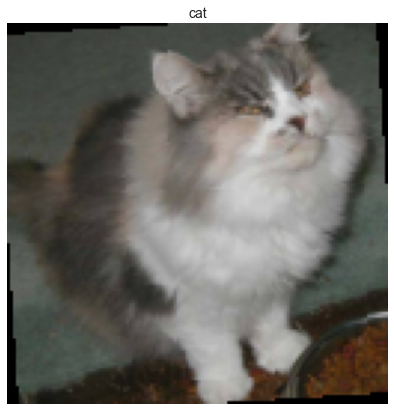

In [20]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14)

In [21]:
train_loader, val_loader

(<torch.utils.data.dataloader.DataLoader at 0x22d8fd6cfd0>,
 <torch.utils.data.dataloader.DataLoader at 0x22d8882af10>)

In [22]:
img, label = next(iter(train_loader))

# Note that batch size will now be 32.
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 128, 128]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


# First model architecture

In [43]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        # Fully connected layer
        self.fc = nn.Linear(256 * 8 * 8, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)  # 128 -> 64
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)  # 64 -> 32
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)  # 32 -> 16
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)  # 16 -> 8
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [45]:
# Instantiate the model
model = SimpleCNN().to(device)

# Attempt 1

In [46]:
# Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [49]:
import time
from datetime import timedelta
from tqdm import tqdm

num_epochs = 10

total_start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc = 100 * val_correct / val_total

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    epoch_duration_formatted = str(timedelta(seconds=int(epoch_duration)))

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, "
          f"Time: {epoch_duration_formatted}")

total_end_time = time.time()
total_training_time = total_end_time - total_start_time
total_training_time_formatted = str(timedelta(seconds=int(total_training_time)))
print(f"Total Training Time: {total_training_time_formatted}")

Training Epoch 1/10: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.65it/s]


Epoch [1/10], Train Loss: 0.8265, Train Acc: 63.36%, Val Loss: 0.8795, Val Acc: 61.00%, Time: 0:00:17


Training Epoch 2/10: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.75it/s]


Epoch [2/10], Train Loss: 0.7352, Train Acc: 66.84%, Val Loss: 0.7170, Val Acc: 64.60%, Time: 0:00:16


Training Epoch 3/10: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.68it/s]


Epoch [3/10], Train Loss: 0.6058, Train Acc: 71.04%, Val Loss: 0.9626, Val Acc: 61.60%, Time: 0:00:16


Training Epoch 4/10: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.68it/s]


Epoch [4/10], Train Loss: 0.6032, Train Acc: 71.64%, Val Loss: 0.7526, Val Acc: 64.60%, Time: 0:00:16


Training Epoch 5/10: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.68it/s]


Epoch [5/10], Train Loss: 0.5694, Train Acc: 73.60%, Val Loss: 0.6507, Val Acc: 70.40%, Time: 0:00:16


Training Epoch 6/10: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.72it/s]


Epoch [6/10], Train Loss: 0.5281, Train Acc: 75.48%, Val Loss: 0.5685, Val Acc: 70.20%, Time: 0:00:16


Training Epoch 7/10: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.69it/s]


Epoch [7/10], Train Loss: 0.4857, Train Acc: 77.28%, Val Loss: 1.0103, Val Acc: 60.20%, Time: 0:00:16


Training Epoch 8/10: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.66it/s]


Epoch [8/10], Train Loss: 0.4964, Train Acc: 76.96%, Val Loss: 0.6373, Val Acc: 70.40%, Time: 0:00:16


Training Epoch 9/10: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.70it/s]


Epoch [9/10], Train Loss: 0.4312, Train Acc: 80.80%, Val Loss: 0.6750, Val Acc: 69.80%, Time: 0:00:16


Training Epoch 10/10: 100%|████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.66it/s]


Epoch [10/10], Train Loss: 0.4181, Train Acc: 81.20%, Val Loss: 0.6051, Val Acc: 72.80%, Time: 0:00:16
Total Training Time: 0:02:46


# Attempt 2

### reduce learning rate of optimizer to 0.0001 from 0.001. and adding scheduler

In [52]:
# Instantiate the model
model2 = SimpleCNN().to(device)

In [53]:
# Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# Adam Optimizer
optimizer = torch.optim.Adam(model2.parameters(), lr=0.0001)

# Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [54]:
import time
from datetime import timedelta
from tqdm import tqdm

num_epochs = 10

total_start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    
    model2.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total

    # Validation
    model2.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model2(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc = 100 * val_correct / val_total
    
    scheduler.step()

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    epoch_duration_formatted = str(timedelta(seconds=int(epoch_duration)))

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, "
          f"Time: {epoch_duration_formatted}")

total_end_time = time.time()
total_training_time = total_end_time - total_start_time
total_training_time_formatted = str(timedelta(seconds=int(total_training_time)))
print(f"Total Training Time: {total_training_time_formatted}")

Training Epoch 1/10: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.77it/s]


Epoch [1/10], Train Loss: 0.7138, Train Acc: 60.88%, Val Loss: 0.6298, Val Acc: 66.80%, Time: 0:00:16


Training Epoch 2/10: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:08<00:00,  8.80it/s]


Epoch [2/10], Train Loss: 0.5968, Train Acc: 68.96%, Val Loss: 0.6228, Val Acc: 64.40%, Time: 0:00:16


Training Epoch 3/10: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.67it/s]


Epoch [3/10], Train Loss: 0.5172, Train Acc: 74.16%, Val Loss: 0.6253, Val Acc: 68.00%, Time: 0:00:16


Training Epoch 4/10: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.33it/s]


Epoch [4/10], Train Loss: 0.4779, Train Acc: 77.00%, Val Loss: 0.5901, Val Acc: 72.20%, Time: 0:00:17


Training Epoch 5/10: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.75it/s]


Epoch [5/10], Train Loss: 0.4940, Train Acc: 77.04%, Val Loss: 0.8868, Val Acc: 60.80%, Time: 0:00:16


Training Epoch 6/10: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:08<00:00,  8.90it/s]


Epoch [6/10], Train Loss: 0.4061, Train Acc: 82.32%, Val Loss: 0.5477, Val Acc: 72.20%, Time: 0:00:16


Training Epoch 7/10: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:08<00:00,  8.92it/s]


Epoch [7/10], Train Loss: 0.3742, Train Acc: 84.48%, Val Loss: 0.5511, Val Acc: 74.40%, Time: 0:00:16


Training Epoch 8/10: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:08<00:00,  8.95it/s]


Epoch [8/10], Train Loss: 0.3687, Train Acc: 84.44%, Val Loss: 0.5260, Val Acc: 74.20%, Time: 0:00:16


Training Epoch 9/10: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:08<00:00,  8.89it/s]


Epoch [9/10], Train Loss: 0.3665, Train Acc: 85.28%, Val Loss: 0.5272, Val Acc: 74.00%, Time: 0:00:16


Training Epoch 10/10: 100%|████████████████████████████████████████████████████████████| 79/79 [00:08<00:00,  8.92it/s]


Epoch [10/10], Train Loss: 0.3637, Train Acc: 85.08%, Val Loss: 0.5238, Val Acc: 73.80%, Time: 0:00:16
Total Training Time: 0:02:45


# Attempt 3: Redefining the architecture, 3 convolutional layers instead of 4. adding a second fully connected layer. increase number of training epochs to 20

In [38]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # ReLU and MaxPool
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # fully connected layers
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 2)
        
        
    def forward(self, x):
        # 128x128 -> 64x64
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # 64x64 -> 32x32
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # 32x32 -> 16x16
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

In [39]:
# Instantiate the model
model = CNN().to(device)

In [40]:
# Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [41]:
import time
from datetime import timedelta
from tqdm import tqdm

num_epochs = 20

total_start_time = time.time()

# for record keeping purposes to plot graph later on
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc = 100 * val_correct / val_total
    
    # add to record keeping purposes
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    scheduler.step()

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    epoch_duration_formatted = str(timedelta(seconds=int(epoch_duration)))

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, "
          f"Time: {epoch_duration_formatted}")

total_end_time = time.time()
total_training_time = total_end_time - total_start_time
total_training_time_formatted = str(timedelta(seconds=int(total_training_time)))
print(f"Total Training Time: {total_training_time_formatted}")

Training Epoch 1/20: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:12<00:00,  6.11it/s]


Epoch [1/20], Train Loss: 0.6944, Train Acc: 63.68%, Val Loss: 0.7797, Val Acc: 57.40%, Time: 0:00:20


Training Epoch 2/20: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.67it/s]


Epoch [2/20], Train Loss: 0.5867, Train Acc: 69.08%, Val Loss: 0.6790, Val Acc: 62.20%, Time: 0:00:16


Training Epoch 3/20: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.49it/s]


Epoch [3/20], Train Loss: 0.5746, Train Acc: 70.36%, Val Loss: 0.5784, Val Acc: 68.80%, Time: 0:00:16


Training Epoch 4/20: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.70it/s]


Epoch [4/20], Train Loss: 0.5114, Train Acc: 75.20%, Val Loss: 0.5835, Val Acc: 70.00%, Time: 0:00:16


Training Epoch 5/20: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.72it/s]


Epoch [5/20], Train Loss: 0.4835, Train Acc: 75.92%, Val Loss: 0.5523, Val Acc: 71.40%, Time: 0:00:16


Training Epoch 6/20: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:08<00:00,  8.79it/s]


Epoch [6/20], Train Loss: 0.4254, Train Acc: 81.12%, Val Loss: 0.5457, Val Acc: 72.20%, Time: 0:00:16


Training Epoch 7/20: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.41it/s]


Epoch [7/20], Train Loss: 0.4182, Train Acc: 81.80%, Val Loss: 0.5428, Val Acc: 72.80%, Time: 0:00:17


Training Epoch 8/20: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.57it/s]


Epoch [8/20], Train Loss: 0.4157, Train Acc: 82.08%, Val Loss: 0.5338, Val Acc: 73.80%, Time: 0:00:16


Training Epoch 9/20: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.66it/s]


Epoch [9/20], Train Loss: 0.4097, Train Acc: 81.88%, Val Loss: 0.5233, Val Acc: 74.80%, Time: 0:00:16


Training Epoch 10/20: 100%|████████████████████████████████████████████████████████████| 79/79 [00:08<00:00,  8.83it/s]


Epoch [10/20], Train Loss: 0.3970, Train Acc: 82.84%, Val Loss: 0.5381, Val Acc: 73.40%, Time: 0:00:16


Training Epoch 11/20: 100%|████████████████████████████████████████████████████████████| 79/79 [00:08<00:00,  8.84it/s]


Epoch [11/20], Train Loss: 0.3985, Train Acc: 83.12%, Val Loss: 0.5331, Val Acc: 73.80%, Time: 0:00:16


Training Epoch 12/20: 100%|████████████████████████████████████████████████████████████| 79/79 [00:08<00:00,  8.90it/s]


Epoch [12/20], Train Loss: 0.3959, Train Acc: 83.20%, Val Loss: 0.5338, Val Acc: 73.80%, Time: 0:00:16


Training Epoch 13/20: 100%|████████████████████████████████████████████████████████████| 79/79 [00:08<00:00,  8.86it/s]


Epoch [13/20], Train Loss: 0.3914, Train Acc: 84.00%, Val Loss: 0.5261, Val Acc: 72.80%, Time: 0:00:16


Training Epoch 14/20: 100%|████████████████████████████████████████████████████████████| 79/79 [00:08<00:00,  8.84it/s]


Epoch [14/20], Train Loss: 0.3956, Train Acc: 83.24%, Val Loss: 0.5348, Val Acc: 75.00%, Time: 0:00:16


Training Epoch 15/20: 100%|████████████████████████████████████████████████████████████| 79/79 [00:08<00:00,  8.81it/s]


Epoch [15/20], Train Loss: 0.3939, Train Acc: 83.08%, Val Loss: 0.5278, Val Acc: 72.40%, Time: 0:00:16


Training Epoch 16/20: 100%|████████████████████████████████████████████████████████████| 79/79 [00:08<00:00,  8.84it/s]


Epoch [16/20], Train Loss: 0.3925, Train Acc: 84.16%, Val Loss: 0.5387, Val Acc: 73.00%, Time: 0:00:16


Training Epoch 17/20: 100%|████████████████████████████████████████████████████████████| 79/79 [00:08<00:00,  8.83it/s]


Epoch [17/20], Train Loss: 0.3879, Train Acc: 83.52%, Val Loss: 0.5340, Val Acc: 73.60%, Time: 0:00:16


Training Epoch 18/20: 100%|████████████████████████████████████████████████████████████| 79/79 [00:08<00:00,  8.78it/s]


Epoch [18/20], Train Loss: 0.3946, Train Acc: 83.04%, Val Loss: 0.5346, Val Acc: 74.80%, Time: 0:00:16


Training Epoch 19/20: 100%|████████████████████████████████████████████████████████████| 79/79 [00:08<00:00,  8.84it/s]


Epoch [19/20], Train Loss: 0.3920, Train Acc: 83.20%, Val Loss: 0.5367, Val Acc: 73.80%, Time: 0:00:16


Training Epoch 20/20: 100%|████████████████████████████████████████████████████████████| 79/79 [00:08<00:00,  8.82it/s]


Epoch [20/20], Train Loss: 0.3994, Train Acc: 82.88%, Val Loss: 0.5381, Val Acc: 74.20%, Time: 0:00:16
Total Training Time: 0:05:35


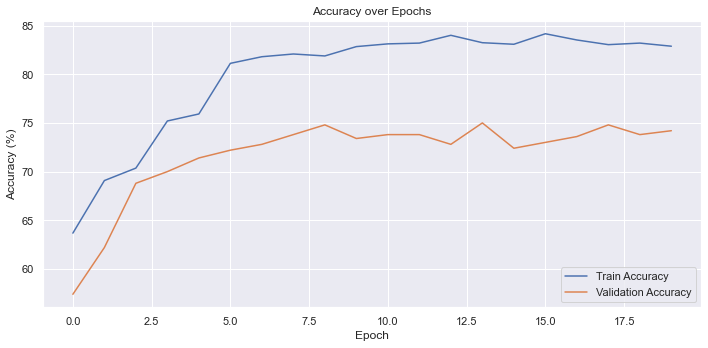

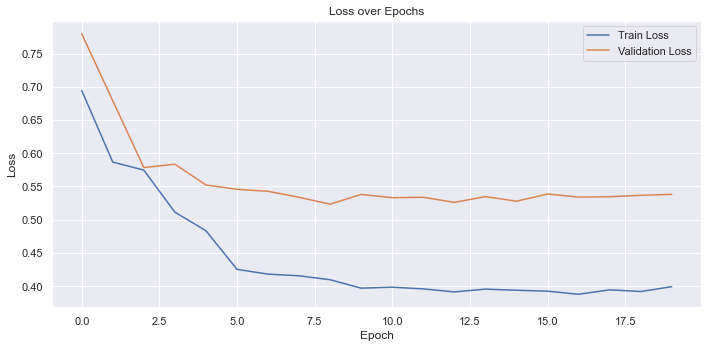

In [42]:
# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Attempt 4: Change model architecture, use SGD instead of Adam optimizer, add dropout

In [48]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # ReLU, MaxPool, and dropout
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
        self.dropout = nn.Dropout(p=0.5)
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # fully connected layers
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 2)
        
    def forward(self, x):
        # 128x128 -> 64x64
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # 64x64 -> 32x32
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # 32x32 -> 16x16
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [49]:
# Instantiate the model
model = CNN().to(device)

In [50]:
# Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [51]:
import time
from datetime import timedelta
from tqdm import tqdm

num_epochs = 20

total_start_time = time.time()

# for record keeping purposes to plot graph later on
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc = 100 * val_correct / val_total
    
    # add to record keeping purposes
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    scheduler.step()

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    epoch_duration_formatted = str(timedelta(seconds=int(epoch_duration)))

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, "
          f"Time: {epoch_duration_formatted}")

total_end_time = time.time()
total_training_time = total_end_time - total_start_time
total_training_time_formatted = str(timedelta(seconds=int(total_training_time)))
print(f"Total Training Time: {total_training_time_formatted}")

Training Epoch 1/20: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.67it/s]


Epoch [1/20], Train Loss: 0.7530, Train Acc: 54.28%, Val Loss: 0.6904, Val Acc: 61.80%, Time: 0:00:16


Training Epoch 2/20: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:08<00:00,  8.82it/s]


Epoch [2/20], Train Loss: 0.6705, Train Acc: 62.68%, Val Loss: 0.6532, Val Acc: 64.80%, Time: 0:00:16


Training Epoch 3/20: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.63it/s]


Epoch [3/20], Train Loss: 0.6467, Train Acc: 64.92%, Val Loss: 0.6373, Val Acc: 66.00%, Time: 0:00:16


Training Epoch 4/20: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.70it/s]


Epoch [4/20], Train Loss: 0.6210, Train Acc: 67.32%, Val Loss: 0.6198, Val Acc: 68.00%, Time: 0:00:16


Training Epoch 5/20: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.73it/s]


Epoch [5/20], Train Loss: 0.5992, Train Acc: 69.52%, Val Loss: 0.6200, Val Acc: 68.20%, Time: 0:00:16


Training Epoch 6/20: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.55it/s]


Epoch [6/20], Train Loss: 0.5970, Train Acc: 69.96%, Val Loss: 0.6115, Val Acc: 69.80%, Time: 0:00:16


Training Epoch 7/20: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:08<00:00,  8.79it/s]


Epoch [7/20], Train Loss: 0.5839, Train Acc: 71.04%, Val Loss: 0.6017, Val Acc: 70.00%, Time: 0:00:16


Training Epoch 8/20: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.61it/s]


Epoch [8/20], Train Loss: 0.5825, Train Acc: 71.44%, Val Loss: 0.6113, Val Acc: 68.00%, Time: 0:00:16


Training Epoch 9/20: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:08<00:00,  8.82it/s]


Epoch [9/20], Train Loss: 0.5744, Train Acc: 72.60%, Val Loss: 0.6113, Val Acc: 69.40%, Time: 0:00:16


Training Epoch 10/20: 100%|████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.78it/s]


Epoch [10/20], Train Loss: 0.5796, Train Acc: 71.24%, Val Loss: 0.6061, Val Acc: 69.20%, Time: 0:00:16


Training Epoch 11/20: 100%|████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.68it/s]


Epoch [11/20], Train Loss: 0.5685, Train Acc: 73.12%, Val Loss: 0.5984, Val Acc: 69.40%, Time: 0:00:16


Training Epoch 12/20: 100%|████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.66it/s]


Epoch [12/20], Train Loss: 0.5695, Train Acc: 73.48%, Val Loss: 0.5960, Val Acc: 70.40%, Time: 0:00:16


Training Epoch 13/20: 100%|████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.66it/s]


Epoch [13/20], Train Loss: 0.5618, Train Acc: 73.64%, Val Loss: 0.6056, Val Acc: 69.60%, Time: 0:00:16


Training Epoch 14/20: 100%|████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.50it/s]


Epoch [14/20], Train Loss: 0.5752, Train Acc: 72.12%, Val Loss: 0.5965, Val Acc: 70.60%, Time: 0:00:17


Training Epoch 15/20: 100%|████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.62it/s]


Epoch [15/20], Train Loss: 0.5727, Train Acc: 72.56%, Val Loss: 0.5973, Val Acc: 71.00%, Time: 0:00:16


Training Epoch 16/20: 100%|████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.55it/s]


Epoch [16/20], Train Loss: 0.5678, Train Acc: 73.84%, Val Loss: 0.6045, Val Acc: 69.20%, Time: 0:00:17


Training Epoch 17/20: 100%|████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.51it/s]


Epoch [17/20], Train Loss: 0.5678, Train Acc: 72.96%, Val Loss: 0.6054, Val Acc: 69.20%, Time: 0:00:16


Training Epoch 18/20: 100%|████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.58it/s]


Epoch [18/20], Train Loss: 0.5740, Train Acc: 72.04%, Val Loss: 0.6021, Val Acc: 70.20%, Time: 0:00:16


Training Epoch 19/20: 100%|████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.44it/s]


Epoch [19/20], Train Loss: 0.5777, Train Acc: 71.12%, Val Loss: 0.5996, Val Acc: 70.20%, Time: 0:00:17


Training Epoch 20/20: 100%|████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.34it/s]


Epoch [20/20], Train Loss: 0.5727, Train Acc: 72.08%, Val Loss: 0.6035, Val Acc: 69.80%, Time: 0:00:17
Total Training Time: 0:05:34


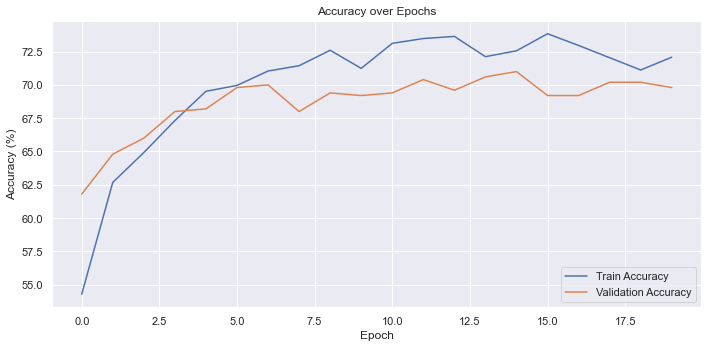

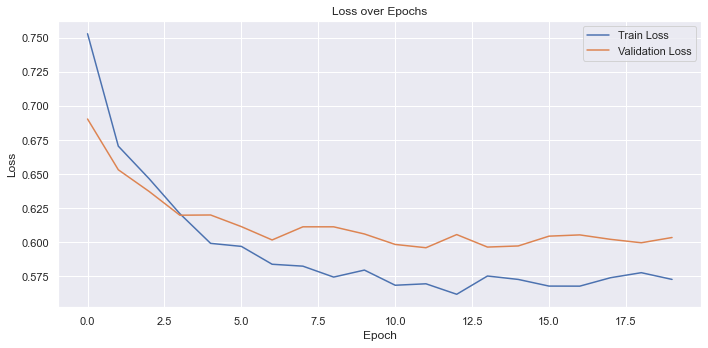

In [52]:
# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Attempt 5: doubling the data from 2500 to 5000. slight increase in acc, 77% acc

In [23]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # ReLU, MaxPool, and dropout
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
        self.dropout = nn.Dropout(p=0.5)
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # fully connected layers
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 2)
        
    def forward(self, x):
        # 128x128 -> 64x64
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # 64x64 -> 32x32
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # 32x32 -> 16x16
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [25]:
# Instantiate the model
model = CNN().to(device)

# Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

import time
from datetime import timedelta
from tqdm import tqdm

num_epochs = 20

total_start_time = time.time()

# for record keeping purposes to plot graph later on
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc = 100 * val_correct / val_total
    
    # add to record keeping purposes
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    scheduler.step()

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    epoch_duration_formatted = str(timedelta(seconds=int(epoch_duration)))

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, "
          f"Time: {epoch_duration_formatted}")

total_end_time = time.time()
total_training_time = total_end_time - total_start_time
total_training_time_formatted = str(timedelta(seconds=int(total_training_time)))
print(f"Total Training Time: {total_training_time_formatted}")

Training Epoch 1/20: 100%|███████████████████████████████████████████████████████████| 157/157 [00:12<00:00, 12.75it/s]


Epoch [1/20], Train Loss: 0.6954, Train Acc: 59.88%, Val Loss: 0.6189, Val Acc: 67.40%, Time: 0:00:20


Training Epoch 2/20: 100%|███████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.41it/s]


Epoch [2/20], Train Loss: 0.6021, Train Acc: 67.38%, Val Loss: 0.5930, Val Acc: 67.40%, Time: 0:00:18


Training Epoch 3/20: 100%|███████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.61it/s]


Epoch [3/20], Train Loss: 0.5703, Train Acc: 70.06%, Val Loss: 0.5744, Val Acc: 70.10%, Time: 0:00:18


Training Epoch 4/20: 100%|███████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.55it/s]


Epoch [4/20], Train Loss: 0.5446, Train Acc: 73.24%, Val Loss: 0.5592, Val Acc: 72.30%, Time: 0:00:18


Training Epoch 5/20: 100%|███████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.41it/s]


Epoch [5/20], Train Loss: 0.5243, Train Acc: 74.34%, Val Loss: 0.5261, Val Acc: 74.70%, Time: 0:00:18


Training Epoch 6/20: 100%|███████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.35it/s]


Epoch [6/20], Train Loss: 0.4866, Train Acc: 77.16%, Val Loss: 0.5071, Val Acc: 76.30%, Time: 0:00:18


Training Epoch 7/20: 100%|███████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.66it/s]


Epoch [7/20], Train Loss: 0.4778, Train Acc: 77.00%, Val Loss: 0.4995, Val Acc: 76.50%, Time: 0:00:18


Training Epoch 8/20: 100%|███████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.30it/s]


Epoch [8/20], Train Loss: 0.4736, Train Acc: 77.74%, Val Loss: 0.4969, Val Acc: 76.30%, Time: 0:00:18


Training Epoch 9/20: 100%|███████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.64it/s]


Epoch [9/20], Train Loss: 0.4597, Train Acc: 78.86%, Val Loss: 0.4907, Val Acc: 76.10%, Time: 0:00:18


Training Epoch 10/20: 100%|██████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.64it/s]


Epoch [10/20], Train Loss: 0.4590, Train Acc: 78.96%, Val Loss: 0.4874, Val Acc: 76.70%, Time: 0:00:18


Training Epoch 11/20: 100%|██████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.46it/s]


Epoch [11/20], Train Loss: 0.4548, Train Acc: 78.92%, Val Loss: 0.4905, Val Acc: 76.60%, Time: 0:00:18


Training Epoch 12/20: 100%|██████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.50it/s]


Epoch [12/20], Train Loss: 0.4585, Train Acc: 78.34%, Val Loss: 0.4910, Val Acc: 76.80%, Time: 0:00:18


Training Epoch 13/20: 100%|██████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.64it/s]


Epoch [13/20], Train Loss: 0.4568, Train Acc: 79.00%, Val Loss: 0.4938, Val Acc: 76.70%, Time: 0:00:18


Training Epoch 14/20: 100%|██████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.57it/s]


Epoch [14/20], Train Loss: 0.4549, Train Acc: 79.70%, Val Loss: 0.4913, Val Acc: 76.70%, Time: 0:00:18


Training Epoch 15/20: 100%|██████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.46it/s]


Epoch [15/20], Train Loss: 0.4517, Train Acc: 79.56%, Val Loss: 0.4866, Val Acc: 77.90%, Time: 0:00:18


Training Epoch 16/20: 100%|██████████████████████████████████████████████████████████| 157/157 [00:11<00:00, 14.20it/s]


Epoch [16/20], Train Loss: 0.4514, Train Acc: 79.52%, Val Loss: 0.4858, Val Acc: 77.10%, Time: 0:00:18


Training Epoch 17/20: 100%|██████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.59it/s]


Epoch [17/20], Train Loss: 0.4411, Train Acc: 80.12%, Val Loss: 0.4882, Val Acc: 77.00%, Time: 0:00:18


Training Epoch 18/20: 100%|██████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.64it/s]


Epoch [18/20], Train Loss: 0.4482, Train Acc: 79.24%, Val Loss: 0.4840, Val Acc: 77.10%, Time: 0:00:18


Training Epoch 19/20: 100%|██████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.57it/s]


Epoch [19/20], Train Loss: 0.4478, Train Acc: 79.50%, Val Loss: 0.4892, Val Acc: 77.20%, Time: 0:00:18


Training Epoch 20/20: 100%|██████████████████████████████████████████████████████████| 157/157 [00:11<00:00, 13.84it/s]


Epoch [20/20], Train Loss: 0.4510, Train Acc: 79.54%, Val Loss: 0.4881, Val Acc: 76.40%, Time: 0:00:19
Total Training Time: 0:06:15


# Attempt 6: redefining architecture, remove dropout, change kernel size to 5, add stride, change padding to 2, remove maxpool/ pooling after conv3 in forward processs

In [27]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # ReLU, MaxPool, and dropout
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(
            in_channels=3, 
            out_channels=32, 
            kernel_size=5, 
            stride=1,
            padding=2
        )
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, 5, 1, 2)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # fully connected layers
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 2)
        
    def forward(self, x):
        # 128x128 -> 64x64
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # 64x64 -> 32x32
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # 32x32 -> 16x16
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

#### try with scheduler first. using adam w it is less common. later try without

In [28]:
# Instantiate the model
model = CNN().to(device)

# Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

import time
from datetime import timedelta
from tqdm import tqdm

num_epochs = 20

total_start_time = time.time()

# for record keeping purposes to plot graph later on
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc = 100 * val_correct / val_total
    
    # add to record keeping purposes
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    scheduler.step()

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    epoch_duration_formatted = str(timedelta(seconds=int(epoch_duration)))

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, "
          f"Time: {epoch_duration_formatted}")

total_end_time = time.time()
total_training_time = total_end_time - total_start_time
total_training_time_formatted = str(timedelta(seconds=int(total_training_time)))
print(f"Total Training Time: {total_training_time_formatted}")

Training Epoch 1/20: 100%|███████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.52it/s]


Epoch [1/20], Train Loss: 0.7101, Train Acc: 59.04%, Val Loss: 0.6491, Val Acc: 66.60%, Time: 0:00:18


Training Epoch 2/20: 100%|███████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.60it/s]


Epoch [2/20], Train Loss: 0.6010, Train Acc: 68.20%, Val Loss: 0.5878, Val Acc: 70.30%, Time: 0:00:18


Training Epoch 3/20: 100%|███████████████████████████████████████████████████████████| 157/157 [00:11<00:00, 14.21it/s]


Epoch [3/20], Train Loss: 0.5506, Train Acc: 72.44%, Val Loss: 0.5866, Val Acc: 69.70%, Time: 0:00:19


Training Epoch 4/20: 100%|███████████████████████████████████████████████████████████| 157/157 [00:11<00:00, 14.25it/s]


Epoch [4/20], Train Loss: 0.5043, Train Acc: 75.78%, Val Loss: 0.5027, Val Acc: 76.40%, Time: 0:00:18


Training Epoch 5/20: 100%|███████████████████████████████████████████████████████████| 157/157 [00:11<00:00, 14.14it/s]


Epoch [5/20], Train Loss: 0.4671, Train Acc: 78.50%, Val Loss: 0.5477, Val Acc: 72.00%, Time: 0:00:19


Training Epoch 6/20: 100%|███████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.37it/s]


Epoch [6/20], Train Loss: 0.4301, Train Acc: 81.32%, Val Loss: 0.4661, Val Acc: 78.50%, Time: 0:00:18


Training Epoch 7/20: 100%|███████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.60it/s]


Epoch [7/20], Train Loss: 0.4229, Train Acc: 81.90%, Val Loss: 0.4596, Val Acc: 78.10%, Time: 0:00:18


Training Epoch 8/20: 100%|███████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.53it/s]


Epoch [8/20], Train Loss: 0.4180, Train Acc: 81.56%, Val Loss: 0.4520, Val Acc: 79.20%, Time: 0:00:18


Training Epoch 9/20: 100%|███████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.61it/s]


Epoch [9/20], Train Loss: 0.4118, Train Acc: 82.04%, Val Loss: 0.4461, Val Acc: 79.90%, Time: 0:00:18


Training Epoch 10/20: 100%|██████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.64it/s]


Epoch [10/20], Train Loss: 0.4098, Train Acc: 82.68%, Val Loss: 0.4467, Val Acc: 79.80%, Time: 0:00:18


Training Epoch 11/20: 100%|██████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.62it/s]


Epoch [11/20], Train Loss: 0.4050, Train Acc: 82.32%, Val Loss: 0.4507, Val Acc: 80.20%, Time: 0:00:18


Training Epoch 12/20: 100%|██████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.56it/s]


Epoch [12/20], Train Loss: 0.4032, Train Acc: 82.50%, Val Loss: 0.4495, Val Acc: 78.70%, Time: 0:00:18


Training Epoch 13/20: 100%|██████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.51it/s]


Epoch [13/20], Train Loss: 0.4026, Train Acc: 82.80%, Val Loss: 0.4515, Val Acc: 80.70%, Time: 0:00:18


Training Epoch 14/20: 100%|██████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.54it/s]


Epoch [14/20], Train Loss: 0.4031, Train Acc: 83.06%, Val Loss: 0.4439, Val Acc: 80.50%, Time: 0:00:18


Training Epoch 15/20: 100%|██████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.47it/s]


Epoch [15/20], Train Loss: 0.4040, Train Acc: 82.72%, Val Loss: 0.4456, Val Acc: 79.40%, Time: 0:00:18


Training Epoch 16/20: 100%|██████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.53it/s]


Epoch [16/20], Train Loss: 0.4006, Train Acc: 83.06%, Val Loss: 0.4438, Val Acc: 79.50%, Time: 0:00:18


Training Epoch 17/20: 100%|██████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.61it/s]


Epoch [17/20], Train Loss: 0.4034, Train Acc: 82.46%, Val Loss: 0.4450, Val Acc: 80.20%, Time: 0:00:18


Training Epoch 18/20: 100%|██████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.55it/s]


Epoch [18/20], Train Loss: 0.4007, Train Acc: 82.60%, Val Loss: 0.4458, Val Acc: 78.60%, Time: 0:00:18


Training Epoch 19/20: 100%|██████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.60it/s]


Epoch [19/20], Train Loss: 0.3992, Train Acc: 83.04%, Val Loss: 0.4450, Val Acc: 79.70%, Time: 0:00:18


Training Epoch 20/20: 100%|██████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.52it/s]


Epoch [20/20], Train Loss: 0.4096, Train Acc: 82.18%, Val Loss: 0.4457, Val Acc: 80.20%, Time: 0:00:18
Total Training Time: 0:06:13


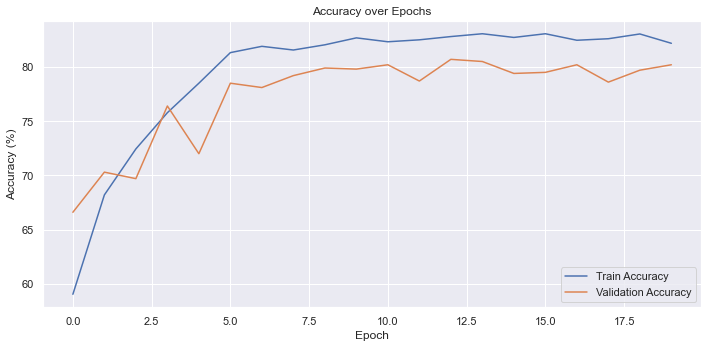

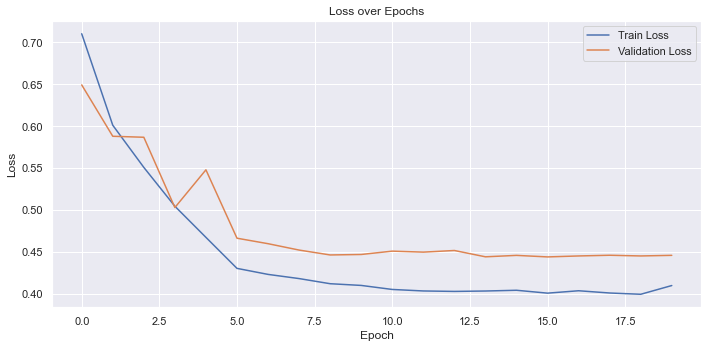

In [29]:
# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
from sklearn.metrics import confusion_matrix, classification_report

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
print(cm)
print(classification_report(y_true, y_pred, target_names=class_names))

[[413  87]
 [114 386]]
              precision    recall  f1-score   support

         cat       0.78      0.83      0.80       500
         dog       0.82      0.77      0.79       500

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000



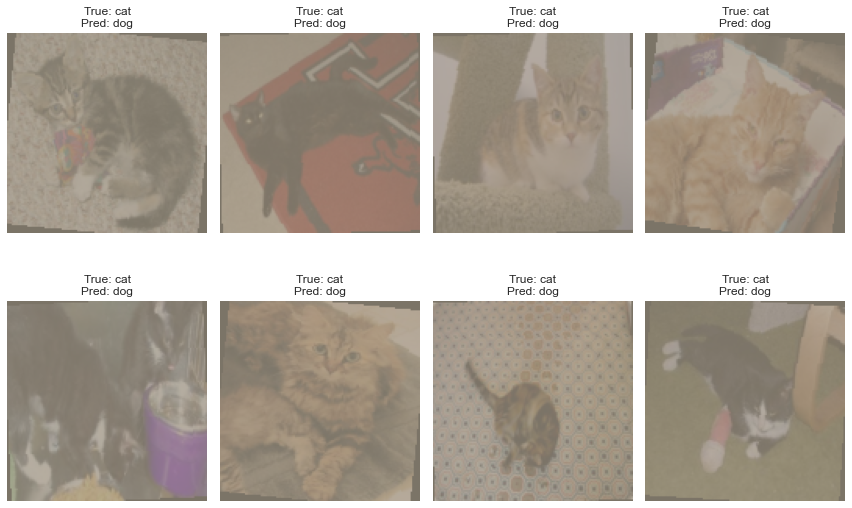

In [32]:
# Initialize lists to store misclassified examples
misclassified_images = []
misclassified_labels = []
misclassified_preds = []

# Validation loop
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Identify misclassified images
        incorrect = (predicted != labels)
        if incorrect.any():
            # Collect misclassified images and labels
            misclassified_images.extend(images[incorrect].cpu())
            misclassified_labels.extend(labels[incorrect].cpu())
            misclassified_preds.extend(predicted[incorrect].cpu())
            
# Define mean and std if you used normalization in your transforms
mean = np.array([0.485, 0.456, 0.406])  # Adjust if different
std = np.array([0.229, 0.224, 0.225])

# Function to unnormalize and display an image
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

# Get class names from your dataset
class_names = train_data.dataset.classes  # Adjust if using Subset

# Plot a few misclassified images
num_images = 8  # Number of images to display
plt.figure(figsize=(12, 8))
for idx in range(num_images):
    if idx >= len(misclassified_images):
        break
    img = misclassified_images[idx]
    true_label = misclassified_labels[idx].item()
    pred_label = misclassified_preds[idx].item()

    plt.subplot(2, 4, idx+1)
    imshow(img)
    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")
plt.tight_layout()
plt.show()